[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zjelveh/zjelveh.github.io/blob/master/files/cfc/7_visualization.ipynb)

**IMPORTANT**: Save your own copy!
1. Click File → Save a copy in Drive
2. Rename it
3. Work in YOUR copy, not the original


---

# 7. Data Visualization - Telling Stories with Pretrial Data
## CCJS 418E: Coding for Criminology


**Today's Goals:**
- Understand why visualization matters more than tables of numbers
- Master four essential plot types: point plots, line plots, histograms, and scatter plots
- Learn the language of seaborn (data, x, y, hue, and other key parameters)
- Use pandas and visualization together to answer policy questions
- Tell compelling stories about Maryland's pretrial reform using data

**Today's Big Question:** Did Maryland's 2016 pretrial reform actually change how judges make decisions about releasing or detaining defendants?

**The Policy Context:** In November 2016, Maryland implemented a major pretrial reform. Before this, judges could set cash bail (hDOB), which meant poor defendants stayed in jail awaiting trial while wealthy defendants could pay their way out. The reform pushed judges toward two clearer options: 
- either release people on their own recognizance (ROR - they promise to come back to court) 
- detain them because they're considered dangerous (HWOB - Held Without Bail). Today we'll use visualization to see if this policy actually changed judicial behavior.

## Part 1: Why Visualize Data?

### The Problem with Tables

Imagine a policymaker asks you: "Did the pretrial reform work?" You could show them a table with 900 rows of numbers (24 counties × 36 months = 864+ rows). They would fall asleep, or worse, miss the story entirely.

**Connection to Computational Thinking: PATTERN RECOGNITION** - Our brains are wired to spot visual patterns instantly but struggle with patterns in tables of numbers. Visualization turns data into insights.

### The Three Questions Visualization Answers

Every good visualization answers one of these questions:

1. **How did something change over TIME?** → Use line plots or point plots
2. **How are values DISTRIBUTED?** → Use histograms  
3. **How do two variables RELATE?** → Use scatter plots

Today we'll learn when to use each type and how to create them.

### Loading Our Data

First, let's load the Maryland pretrial decisions dataset. This contains monthly data from every county from 2016-2018.

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pretrial decisions data
df = pd.read_csv('https://raw.githubusercontent.com/zjelveh/zjelveh.github.io/refs/heads/master/files/cfc/bail_decisions_monthly.csv')
df.drop(columns=['pct_felony'], inplace=True)
df = df[df.county!='STATEWIDE']
# Let's peek at what we have
df.head()

,county,year,month,year_month_str,months_from_reform,n_total_hearings,n_felony_hearings,n_ror,n_hdob,n_hwob,pct_ror,pct_hdob,pct_hwob
0,Allegany,2016,1,2016-01,-10,71,10,21,36,14,29.577465,50.704225,19.718310
1,Allegany,2016,2,2016-02,-9,91,14,21,54,16,23.076923,59.340659,17.582418
2,Allegany,2016,3,2016-03,-8,72,5,20,37,15,27.777778,51.388889,20.833333
3,Allegany,2016,4,2016-04,-7,85,11,26,47,12,30.588235,55.294118,14.117647
4,Allegany,2016,5,2016-05,-6,96,8,27,52,17,28.125000,54.166667,17.708333


### Understanding Our Data Structure

Before we visualize anything, we need to understand what each row represents and what each column means. This is crucial!

In [23]:
# Check the shape - how many rows and columns?
print(f"Dataset has {len(df)} rows and {len(df.columns)} columns")

# What are all the columns?
print("\nColumn names:")
print(df.columns.tolist())

# How many counties do we have?
print(f"\nNumber of unique counties: {df['county'].nunique()}")
print(f"Counties: {df['county'].unique()}")

# What's the time range?
print(f"\nData spans from {df['year'].min()} to {df['year'].max()}")

Dataset has 864 rows and 13 columns

Column names:
['county', 'year', 'month', 'year_month_str', 'months_from_reform', 'n_total_hearings', 'n_felony_hearings', 'n_ror', 'n_hdob', 'n_hwob', 'pct_ror', 'pct_hdob', 'pct_hwob']

Number of unique counties: 24
Counties: ['Allegany' 'Anne Arundel' 'Baltimore' 'Baltimore City' 'Calvert'
 'Caroline' 'Carroll' 'Cecil' 'Charles' 'Dorchester' 'Frederick' 'Garrett'
 'Harford' 'Howard' 'Kent' 'Montgomery' 'Prince George' 'Queen Anne'
 'Saint Mary' 'Somerset' 'Talbot' 'Washington' 'Wicomico' 'Worcester']

Data spans from 2016 to 2018


**Key Variables to Understand:**

- `county`: Which Maryland county (24 total)
- `year`, `month`: When this data is from  
- `months_from_reform`: The key variable! Negative = before reform (Nov 2016), 0 = reform month, positive = after reform
- `n_total_hearings`: How many bail hearings happened that month
- `n_ror`: How many people were Released on Recognizance (ROR)
- `n_hdob`: How many people were Held Detained on Bail (HDOB)
- `n_hwob`: How many people were Held With Opportunity for Bail (HWOB - traditional cash bail)
- `pct_ror`, `pct_hdob`, `pct_hwob`: The percentages (these are what we'll visualize most)

**Quick Check 1:** Why might it be better to visualize percentages (`pct_ror`) rather than counts (`n_ror`)? Think about how county sizes differ.

<details>
<summary>Click for answer</summary>

Percentages let us compare counties fairly. Prince George's County might have 400 ROR decisions and Allegany County might have 30, but that's because PG is way bigger! Looking at the *percentage* released tells us about judicial behavior regardless of county size.

</details>

## Part 2: Point Plots - Showing Trends with Confidence

### Starting Simple: One County, One Variable

**The Question:** How did Prince George's County's ROR rate change over time?

**Why start with one county?** It's easier to understand patterns when we're not looking at all 24 counties at once. Prince George's is Maryland's second-largest county and shows interesting trends.

In [24]:
# Filter to just Prince George's County
# Remember this from Week 6 - filtering!
pg_data = df[df['county'] == "Prince George"]

# Let's see what we're working with
print(f"We have {len(pg_data)} months of data for PG County")
print(f"From {pg_data['year'].min()}/{pg_data['month'].min()} to {pg_data['year'].max()}/{pg_data['month'].max()}")

We have 36 months of data for PG County
From 2016/1 to 2018/12


### Practice: Create a pct_felony column

In [25]:
# create a column called pct_felony that is the share of initial hearings w/ a felony charge

###CODE HERE

### Creating Our First Point Plot

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='months_from_reform', ylabel='pct_ror'>

Text(0.5, 1.0, "Release on Recognizance Rate in Prince George's County")

Text(0.5, 0, 'Months from Reform (0 = November 2016)')

Text(0, 0.5, 'Percent Released on Recognizance')

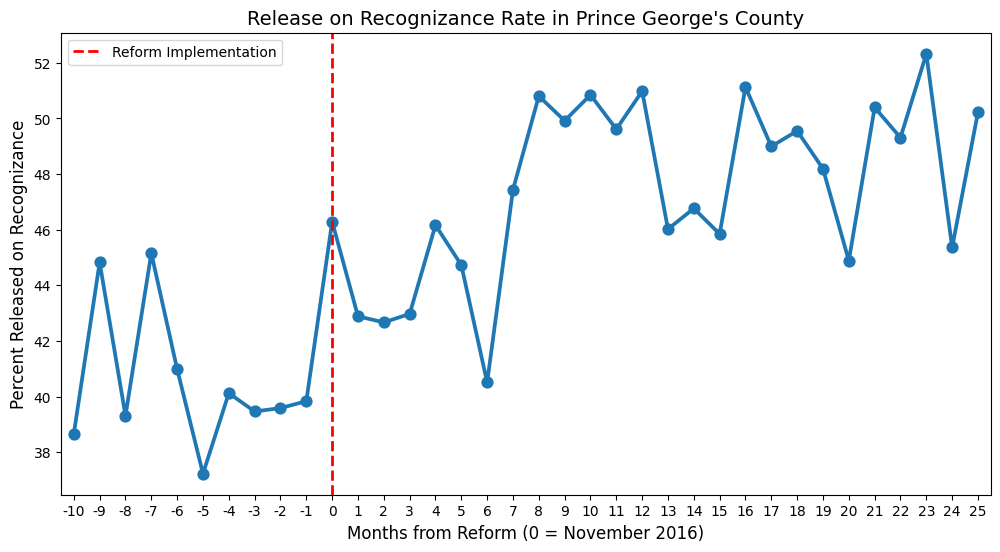

In [26]:
# Create a figure - this is like setting up a canvas
plt.figure(figsize=(12, 6))  # Width=12 inches, height=6 inches

# Create the point plot
sns.pointplot(data=pg_data,           # Which DataFrame to use
              x='months_from_reform',  # What goes on x-axis (time)
              y='pct_ror')            # What goes on y-axis (outcome)

# Add labels so people understand what they're seeing
plt.title("Release on Recognizance Rate in Prince George's County", fontsize=14)
plt.xlabel("Months from Reform (0 = November 2016)", fontsize=12)
plt.ylabel("Percent Released on Recognizance", fontsize=12)

# Add a vertical line at the reform date
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Reform Implementation')
plt.legend()

# Display the plot
plt.show()

### Understanding What You're Seeing

Let's break down every element of this plot:

**The dots:** Each dot represents the ROR rate for that month. In this case, since we only have one county, there's exactly one dot per month.

**The vertical lines through each dot:** These show the spread of the data at each time point. With only one county, they're very short. Later when we plot all counties together, these will show how much variation exists across counties.

**The x-axis:** `months_from_reform` lets us see before and after the reform. Negative numbers = before, positive = after.

**The red dashed line:** This marks when the reform happened (month 0). It helps our eyes see the "before" and "after" story.

**What's the story here?** The ROR rate jumps dramatically right at the reform! Before the reform, PG County released about 57% of people on recognizance. After the reform, it jumped to 68-70%. The reform worked in PG County!

### Anatomy of a Seaborn Function Call

Let's break down the `sns.pointplot()` function parameter by parameter:

<Axes: xlabel='months_from_reform', ylabel='pct_ror'>

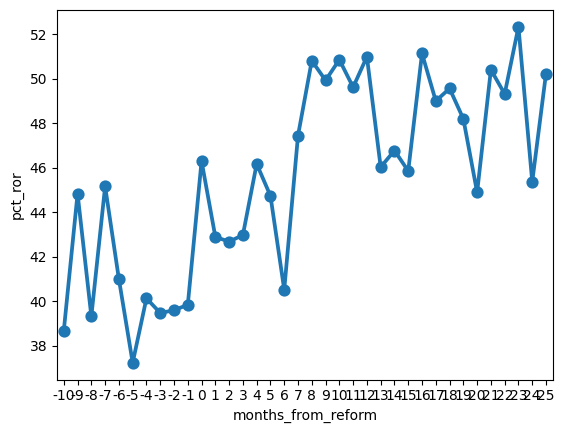

In [27]:
sns.pointplot(
    data=pg_data,            # Which DataFrame contains your data
    x='months_from_reform',  # Column name for x-axis (usually time or categories)
    y='pct_ror'             # Column name for y-axis (usually the outcome you're measuring)
)

**Every seaborn function follows this pattern:** `data=`, `x=`, and `y=` are the three core parameters you'll use again and again.

### Quick Check 2

Before running this code, predict what you'll see:

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='months_from_reform', ylabel='pct_hdob'>

Text(0.5, 1.0, "Detention Rate in Prince George's County")

Text(0.5, 0, 'Months from Reform')

Text(0, 0.5, 'Percent Held Detained on Bail')

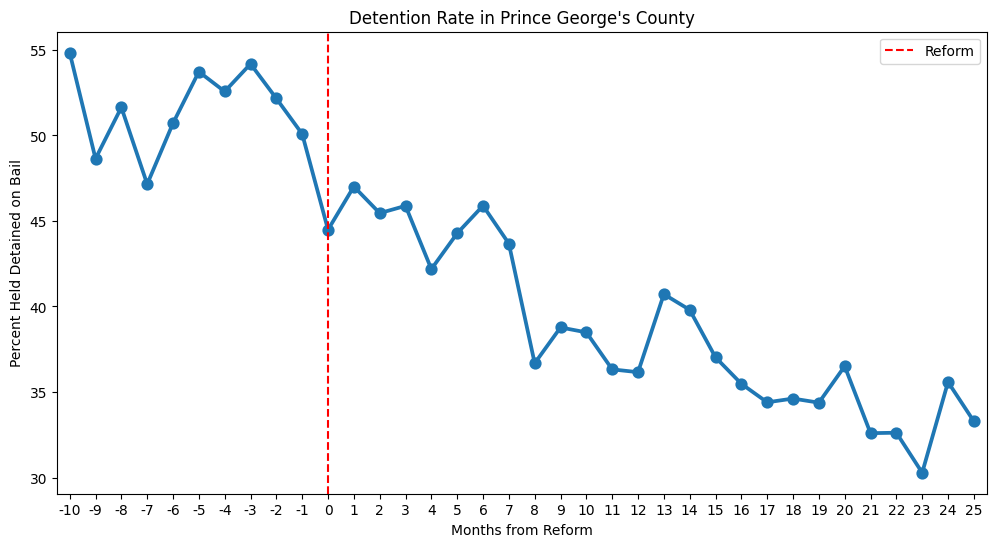

In [28]:
plt.figure(figsize=(12, 6))
sns.pointplot(data=pg_data, 
              x='months_from_reform', 
              y='pct_hdob')  # Detention rate instead of ROR
              
plt.title("Detention Rate in Prince George's County")
plt.xlabel("Months from Reform")
plt.ylabel("Percent Held Detained on Bail")
plt.axvline(x=10, color='red', linestyle='--', label='Reform')
plt.legend()
plt.show()

What do you expect? Will detention go up or down when ROR goes up?

<details>
<summary>Click for answer</summary>

Detention should go DOWN when ROR goes up! If more people are being released (ROR going up), fewer must be detained. These two outcomes are related - they have to add up (along with HWOB) to roughly 100%.

</details>

## Part 3: Line Plots - Emphasizing Continuous Trends

### Line Plots vs Point Plots

Both line plots and point plots show trends over time, but they emphasize different things:

- **Point plots:** Emphasize individual time points and their uncertainty. Better for discrete time periods.
- **Line plots:** Emphasize the continuous flow and trajectory. Better when you want viewers to follow the trend smoothly.

### Creating a Line Plot

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='months_from_reform', ylabel='pct_hdob'>

Text(0.5, 1.0, "Detention Rate in Prince George's County")

Text(0.5, 0, 'Months from Reform')

Text(0, 0.5, 'Percent Held Detained on Bail')

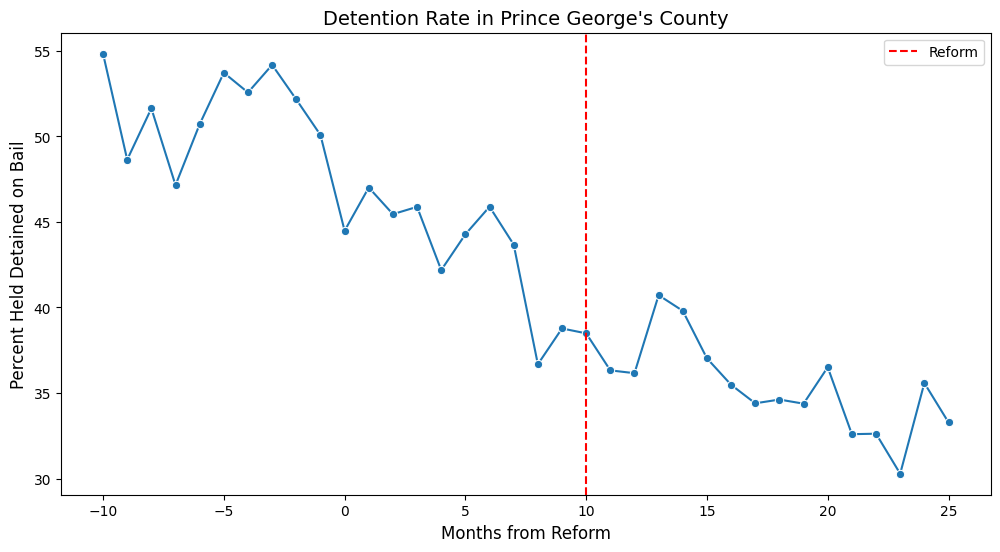

In [29]:
# Same data, different plot type
plt.figure(figsize=(12, 6))

sns.lineplot(data=pg_data,           # Same parameters as before
             x='months_from_reform', 
             y='pct_hdob',
             marker='o')              # This adds dots at each data point

plt.title("Detention Rate in Prince George's County", fontsize=14)
plt.xlabel("Months from Reform", fontsize=12)
plt.ylabel("Percent Held Detained on Bail", fontsize=12)
plt.axvline(x=10, color='red', linestyle='--', label='Reform')
plt.legend()
plt.show()

### New Parameter: `marker`

The `marker='o'` parameter adds small circles at each actual data point. This is helpful because:
- It shows you where you actually have data (vs the line just connecting them)
- It makes the plot more readable
- Other marker options: `'s'` (square), `'^'` (triangle), `'D'` (diamond)

### The Visual Difference

With a **line plot**, your eye follows the line and sees the trajectory. With a **point plot**, your eye focuses on each individual point. For monthly data like this, where we want to see the trend over time, line plots often work better.

**Rule of thumb:** Use line plots when time is continuous and you want to emphasize the trend. Use point plots when you want to emphasize individual measurements or compare groups (which we'll do next!).

## Part 4: The Power of Hue - Comparing Groups

### What is "Hue"?

`hue` is one of the most powerful parameters in seaborn. It means "color" - but more importantly, it means **split your data into groups and show each group in a different color**.

Think of it like this:
- Without `hue`: One line showing all the data
- With `hue`: Multiple lines, one for each group, each in a different color

### Creating Groups: Large vs Small Counties

Before we can use `hue`, we need to create a grouping variable. Let's classify counties as "large" or "small" based on how many hearings they have.

In [30]:
# Step 1: Calculate total hearings per county across all time
# This uses groupby from Week 7!
county_sizes = df.groupby('county')['n_total_hearings'].sum().reset_index()
county_sizes.columns = ['county', 'total_hearings']

# Let's peek at this
print("Counties ranked by total hearings:")
print(county_sizes.sort_values('total_hearings', ascending=False))

Counties ranked by total hearings:
            county  total_hearings
3   Baltimore City           32536
16   Prince George           22848
2        Baltimore           20172
1     Anne Arundel           13910
15      Montgomery           10814
23       Worcester            4848
10       Frederick            4758
22        Wicomico            4514
12         Harford            4447
21      Washington            4428
13          Howard            4084
8          Charles            3986
0         Allegany            3703
7            Cecil            3604
6          Carroll            2419
4          Calvert            2404
18      Saint Mary            2051
9       Dorchester            1490
20          Talbot            1080
17      Queen Anne            1070
5         Caroline             986
11         Garrett             703
19        Somerset             692
14            Kent             389


In [31]:
df['large_county'] = df.county.isin(['Baltimore City', 'Prince George', 'Baltimore', 'Anne Arundel', 
'Montgomery'])



### Using Hue to Compare Groups

Now comes the magic! We'll plot ROR trends for ALL counties, but color them by size.

<Axes: xlabel='months_from_reform', ylabel='pct_ror'>

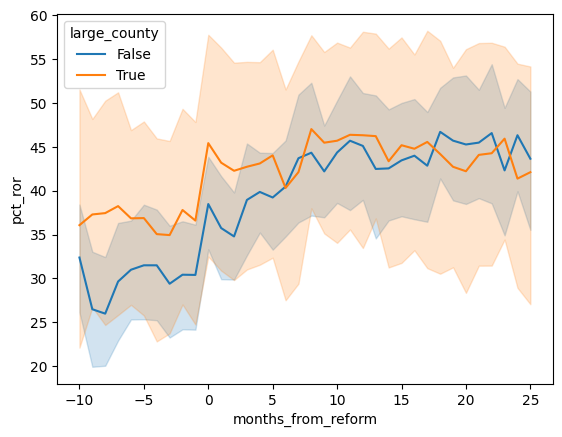

In [34]:
sns.lineplot(data=df,                    # Now using full dataset, not just PG
             x='months_from_reform', 
             y='pct_ror',
             hue='large_county')        #  split by county size




## Part 5: Histograms - Understanding Distributions

### A Different Kind of Question

So far we've looked at **trends over time**. Now let's ask a different question: **How are values distributed?**

**Example question:** How much do counties vary in their felony rates? Do most counties see similar percentages of felony cases, or is there huge variation?

A histogram answers this question by showing us the **distribution** - how many observations fall into different ranges.

### Creating a Basic Histogram

In [37]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df,              # Our full dataset
             x='pct_felony',        # What variable to show the distribution of
             bins=30,               # How many bars (bins) to create
             kde=True)              # Add a smooth curve

plt.title("Distribution of Felony Rates Across All County-Months", fontsize=14)
plt.xlabel("Percent Felony Cases", fontsize=12)
plt.ylabel("Count of County-Months", fontsize=12)
plt.show()

<Figure size 1000x600 with 0 Axes>

ValueError: Could not interpret value `pct_felony` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

### Understanding Histograms

**What each bar represents:** Each bar shows how many county-month observations fall in that range. For example, the tallest bar might be around 10-15% felonies, meaning "most county-months have felony rates between 10-15%."

**The x-axis:** Shows the possible values of felony percentage (from 0% to 30% in our data).

**The y-axis:** Shows the COUNT - how many observations fall in each range. Higher bars = more common values.

**The blue curve (KDE):** Stands for "Kernel Density Estimate." It's a smooth version of the histogram. Think of it as smoothing out the jagged bars to show the overall shape of the distribution.

### Key Parameters Explained

**`bins=30`:** How many bars to create. This is crucial!
- Too few bins (like 5): You lose detail, everything gets lumped together  
- Too many bins (like 100): Each bar is too narrow, looks choppy
- Rule of thumb: Start with 20-30 for most data

Let's see the difference:

ValueError: Could not interpret value `pct_felony` for `x`. An entry with this name does not appear in `data`.

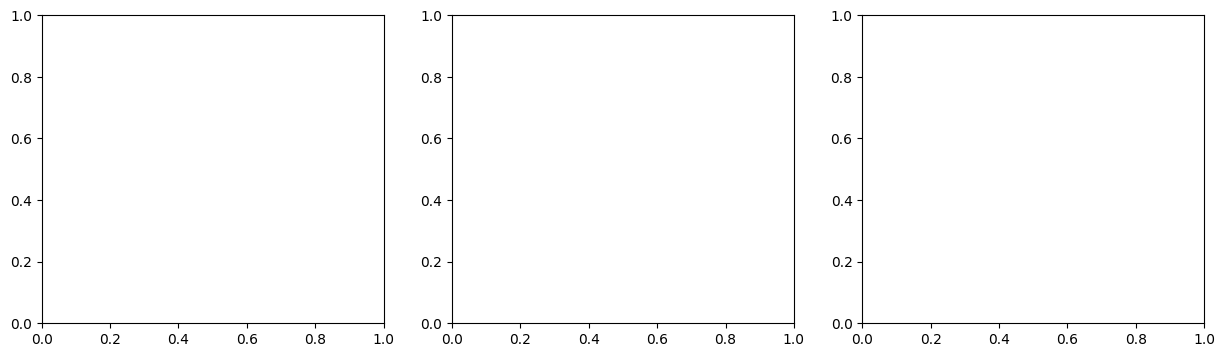

In [38]:
# Compare different bin sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Too few bins
sns.histplot(data=df, x='pct_felony', bins=5, kde=True, ax=axes[0])
axes[0].set_title('Too Few Bins (5)')

# Just right
sns.histplot(data=df, x='pct_felony', bins=30, kde=True, ax=axes[1])
axes[1].set_title('Good Number of Bins (30)')

# Too many bins  
sns.histplot(data=df, x='pct_felony', bins=100, kde=True, ax=axes[2])
axes[2].set_title('Too Many Bins (100)')

plt.tight_layout()
plt.show()

**`kde=True`:** Whether to add the smooth curve. KDE stands for Kernel Density Estimate.
- `kde=True`: Shows the smooth curve (usually helpful)
- `kde=False`: Just bars, no curve

### What Does This Distribution Tell Us?

Looking at the felony distribution, we can see:
- **Most county-months are in the 8-15% range** - this is typical
- **Some counties go as high as 25-30%** - these are outliers worth investigating  
- **The distribution is roughly bell-shaped** but with a longer tail on the right (called "right-skewed")

**Why this matters for policy:** If we know most counties see 10% felonies, and suddenly a county jumps to 25%, that's a red flag worth investigating. Are they charging more serious crimes? Is there a crime spike?

### Quick Check 4

What would a histogram of `pct_ror` look like? Before running the code, predict:
- Will it be bell-shaped or have two peaks?  
- What range will most counties fall in?

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='pct_ror', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of ROR Rates')

Text(0.5, 0, 'Percent Released on Recognizance')

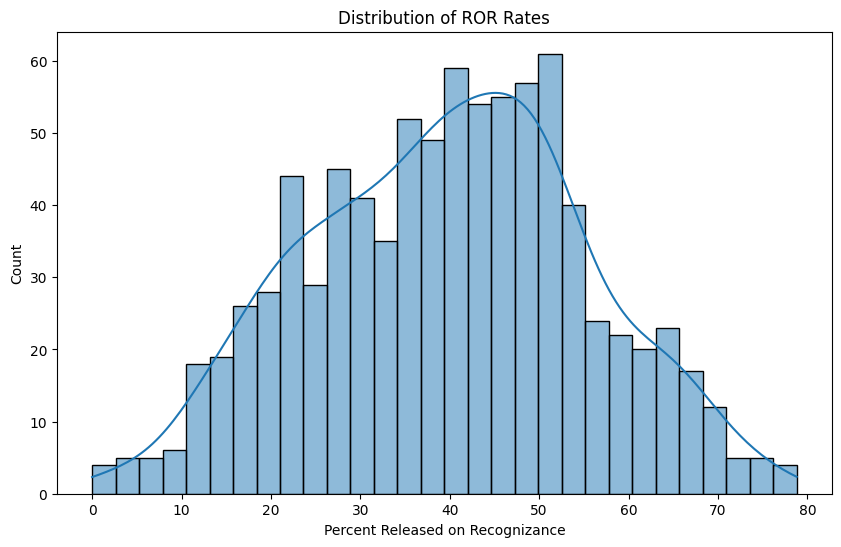

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='pct_ror', bins=30, kde=True)
plt.title("Distribution of ROR Rates")
plt.xlabel("Percent Released on Recognizance")
plt.show()

<details>
<summary>Click for answer</summary>

You might see TWO peaks (called "bimodal")! This happens because there was a reform - counties before the reform clustered around one ROR rate, and counties after the reform clustered around a higher rate. This is a visual sign of the policy change!

</details>


## Part 8: Bar Charts - Comparing Categories

### A New Kind of Comparison

So far we've looked at trends over time and distributions of values. Now let's tackle a different question that requires a different visualization approach.

**The Question:** For each county, what was the average ROR rate before the reform versus after the reform? We want to see which counties changed the most.

This question is asking us to **compare categories** (counties) across **groups** (pre vs post). Bar charts are perfect for this! They let us line up categories side by side and compare their values visually.

**When to use bar charts:**
- Comparing values across categories (like counties, crime types, policy periods)
- When you want to show the magnitude of something for different groups
- When categories are discrete (not continuous like time)

**When NOT to use bar charts:**
- For trends over many time points (use line plots instead)
- For distributions of continuous variables (use histograms instead)

### Preparing Data with Groupby

Before we can make a bar chart comparing pre and post reform rates by county, we need to aggregate our data. This is where your Week 7 groupby skills become essential!

We need to group by TWO things: county AND period, then calculate the average ROR rate for each combination.

In [42]:
# Step 1: Make sure we have the period column (we created this earlier)
# If you're starting fresh, uncomment this:
df['period'] = df['months_from_reform'].apply(
    lambda x: 'Pre-Reform' if x < 0 else 'Post-Reform'
)

# Step 2: Group by county AND period, calculate average ROR
county_period_avg = df.groupby(['county', 'period'])['pct_ror'].mean().reset_index()

# Let's look at what we created
print("First 10 rows of our aggregated data:")
print(county_period_avg.head(10))
print(f"\nTotal rows: {len(county_period_avg)}")
print("(Should be about 48 rows: 24 counties × 2 periods)")

First 10 rows of our aggregated data:
           county       period    pct_ror
0        Allegany  Post-Reform  38.837726
1        Allegany   Pre-Reform  29.909698
2    Anne Arundel  Post-Reform  65.336646
3    Anne Arundel   Pre-Reform  56.739638
4       Baltimore  Post-Reform  35.969640
5       Baltimore   Pre-Reform  25.702848
6  Baltimore City  Post-Reform  48.496325
7  Baltimore City   Pre-Reform  42.738182
8         Calvert  Post-Reform  54.779709
9         Calvert   Pre-Reform  25.750331

Total rows: 48
(Should be about 48 rows: 24 counties × 2 periods)


### Understanding This Groupby

Let's break down what `df.groupby(['county', 'period'])['pct_ror'].mean()` does step by step:

**Step 1:** `groupby(['county', 'period'])` splits our data into groups. Each unique combination of county and period gets its own group. So we get groups like:
- Allegany + Pre-Reform
- Allegany + Post-Reform  
- Anne Arundel + Pre-Reform
- Anne Arundel + Post-Reform
- ... and so on for all 24 counties

**Step 2:** `['pct_ror']` says "we only care about the ROR percentage column"

**Step 3:** `.mean()` calculates the average ROR rate within each group. For example, it takes all the Allegany Pre-Reform months (10 months of data) and averages them to get one number: "Allegany's average pre-reform ROR rate was X%"

**Step 4:** `.reset_index()` converts the result back into a normal DataFrame with columns we can easily work with

The result is a clean DataFrame where each row represents one county-period combination with its average ROR rate.

### Creating Our First Bar Chart - Hued by Period

Now let's visualize this data! We'll create a bar chart where each county gets TWO bars: one for pre-reform and one for post-reform.

<Figure size 1400x600 with 0 Axes>

<Axes: xlabel='county', ylabel='pct_ror'>

Text(0.5, 1.0, 'Average ROR Rates by County: Before vs After Reform')

Text(0.5, 0, 'County')

Text(0, 0.5, 'Average ROR Rate (%)')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'Allegany'),
  Text(1, 0, 'Anne Arundel'),
  Text(2, 0, 'Baltimore'),
  Text(3, 0, 'Baltimore City'),
  Text(4, 0, 'Calvert'),
  Text(5, 0, 'Caroline'),
  Text(6, 0, 'Carroll'),
  Text(7, 0, 'Cecil'),
  Text(8, 0, 'Charles'),
  Text(9, 0, 'Dorchester'),
  Text(10, 0, 'Frederick'),
  Text(11, 0, 'Garrett'),
  Text(12, 0, 'Harford'),
  Text(13, 0, 'Howard'),
  Text(14, 0, 'Kent'),
  Text(15, 0, 'Montgomery'),
  Text(16, 0, 'Prince George'),
  Text(17, 0, 'Queen Anne'),
  Text(18, 0, 'Saint Mary'),
  Text(19, 0, 'Somerset'),
  Text(20, 0, 'Talbot'),
  Text(21, 0, 'Washington'),
  Text(22, 0, 'Wicomico'),
  Text(23, 0, 'Worcester')])

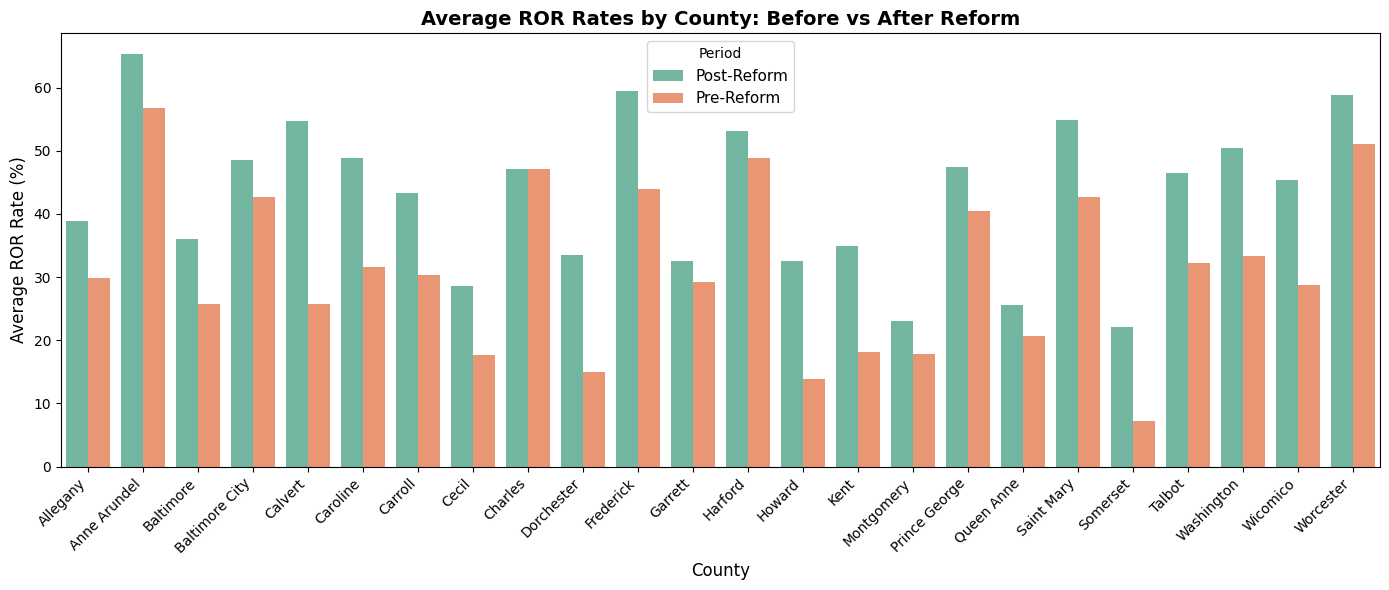

In [43]:
plt.figure(figsize=(14, 6))

sns.barplot(data=county_period_avg,
            x='county',
            y='pct_ror',
            hue='period',           # This creates two bars per county
            palette='Set2')         # A nice color scheme

plt.title("Average ROR Rates by County: Before vs After Reform", fontsize=14, fontweight='bold')
plt.xlabel("County", fontsize=12)
plt.ylabel("Average ROR Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate county names so they don't overlap
plt.legend(title='Period', fontsize=11)
plt.tight_layout()
plt.show()

### Understanding Bar Charts with Hue

Let's break down what you're seeing in this plot:

**The x-axis:** Each position along the x-axis represents one county. You'll see all 24 Maryland counties listed.

**The bars:** At each county position, you see TWO bars standing side by side. One bar shows the pre-reform average (in one color), and the other shows the post-reform average (in another color). The height of each bar represents the average ROR rate.

**The hue parameter magic:** By setting `hue='period'`, seaborn automatically:
- Creates two bars per county (one per period)
- Colors them differently so you can tell them apart
- Creates a legend showing which color means what
- Places them side by side so you can easily compare

**Reading the story:** Your eyes can quickly scan across and see which counties have big gaps between the two bars (big reform effect) versus counties where the bars are similar heights (smaller reform effect). This is the power of bar charts - they make comparisons immediate and visual!

### New Parameters Explained

**`palette='Set2'`:** This controls the color scheme. Seaborn has built-in palettes with nice color combinations:
- `'Set2'`: Soft, muted colors (good for publication)
- `'deep'`: Rich, saturated colors (default)
- `'pastel'`: Very light colors
- `'colorblind'`: Designed to be distinguishable for colorblind viewers (highly recommended!)

Try changing this to see different color schemes!

**`plt.xticks(rotation=45, ha='right')`:** This rotates the county names 45 degrees so they don't overlap. The `ha='right'` means "horizontal alignment = right" which makes the rotated text line up nicely with the bars.

Without this rotation, county names would pile on top of each other and become unreadable. This is a common issue when you have many categories on the x-axis!

### Alternative Visualization - Hued by County

Now let's flip our perspective! Instead of showing all counties with pre/post bars, let's show just pre and post with county bars. This helps us see which counties dominate the averages.

But wait - with 24 counties, we'd have 24 different colored bars, which would be chaos! Let's be smarter and pick just the largest counties to compare.

In [ ]:
# First, let's identify the 5 largest counties by total hearings
largest_counties = df.groupby('county')['n_total_hearings'].sum().nlargest(5).index.tolist()
print(f"Five largest counties: {largest_counties}")

# Filter our aggregated data to just these counties
large_county_data = county_period_avg[county_period_avg['county'].isin(largest_counties)]

# Now create a bar chart with counties as different colors
plt.figure(figsize=(10, 6))

sns.barplot(data=large_county_data,
            x='period',
            y='pct_ror',
            hue='county',            # Now county is the hue!
            palette='colorblind')     # Good for accessibility

plt.title("ROR Rates in Maryland's 5 Largest Counties: Pre vs Post Reform", 
          fontsize=14, fontweight='bold')
plt.xlabel("Period", fontsize=12)
plt.ylabel("Average ROR Rate (%)", fontsize=12)
plt.legend(title='County', fontsize=10, loc='best')
plt.tight_layout()
plt.show()

### Understanding This Alternative View

This flipped perspective reveals different insights:

**The x-axis:** Now we just have two positions: Pre-Reform and Post-Reform

**The bars:** At each period, we see FIVE bars (one for each of our largest counties), each in a different color

**What this reveals:** Instead of asking "how did each county change?", we're asking "which counties had the highest ROR rates before the reform? Which had the highest after? Did the rankings change?"

**The story:** You might notice that some counties were high-ROR counties even before the reform, while others started low and jumped up. This tells us that counties had different baseline practices, and the reform affected them differently.

### The Power of Perspective

These two bar charts show the SAME DATA but tell different stories:

**First chart (hue='period'):** Best for answering "Which counties changed the most after the reform?" Your eyes scan horizontally across counties and look for big gaps between the two bars.

**Second chart (hue='county'):** Best for answering "Which counties were already releasing people frequently? Which counties changed their ranking?" Your eyes compare bar heights within each period.

This is an important lesson in data visualization: the same data can be arranged different ways to highlight different insights. Always think about what question you're trying to answer, then choose the arrangement that makes that answer most obvious.

### Sorting Bars for Better Insights

One problem with our first bar chart is that counties appear in alphabetical order, which doesn't reveal much. Let's sort them by how much they changed!

In [ ]:
# Calculate the change in ROR rate for each county
# First, pivot so we have pre and post as separate columns
county_change = county_period_avg.pivot(index='county', 
                                         columns='period', 
                                         values='pct_ror').reset_index()
county_change.columns.name = None  # Remove the column index name

# Calculate the change
county_change['change'] = county_change['Post-Reform'] - county_change['Pre-Reform']

# Sort by change (biggest increase first)
county_change_sorted = county_change.sort_values('change', ascending=False)

print("Counties ranked by ROR increase:")
print(county_change_sorted[['county', 'Pre-Reform', 'Post-Reform', 'change']].head(10))

This is advanced pandas manipulation! Let's understand what `.pivot()` does:

**Before pivot:** Our data has rows like:
```
Allegany, Pre-Reform, 30.5
Allegany, Post-Reform, 38.2
Anne Arundel, Pre-Reform, 57.1
Anne Arundel, Post-Reform, 65.3
```

**After pivot:** We reshape it to have pre and post as columns:
```
Allegany,     30.5,         38.2,       7.7
Anne Arundel, 57.1,         65.3,       8.2
```

Now we can easily calculate the change by subtracting columns!

### Creating a Sorted Bar Chart

Now let's plot this, sorted by change:

In [ ]:
plt.figure(figsize=(14, 6))

# We need to reshape back for plotting
county_change_long = county_change_sorted.melt(id_vars=['county', 'change'],
                                                value_vars=['Pre-Reform', 'Post-Reform'],
                                                var_name='period',
                                                value_name='pct_ror')

sns.barplot(data=county_change_long,
            x='county',
            y='pct_ror',
            hue='period',
            palette='Set2',
            order=county_change_sorted['county'])  # This controls the order!

plt.title("Counties Ranked by Reform Impact (Largest Increase First)", 
          fontsize=14, fontweight='bold')
plt.xlabel("County", fontsize=12)
plt.ylabel("Average ROR Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Period', fontsize=11)
plt.tight_layout()
plt.show()

### The `order` Parameter

The `order` parameter is incredibly useful! It lets you control exactly what order categories appear in on your x-axis. Here we're ordering counties by their reform impact, so counties with the biggest increases appear first.

Without `order`, seaborn would put counties in alphabetical order (the default). With `order`, we can arrange them by any logic we want: biggest to smallest, smallest to biggest, or any custom ordering.

This makes the chart tell a much clearer story: you can immediately see which counties were most affected by the reform!

### Quick Check 5

Looking at the sorted bar chart, answer these questions:
1. Which county had the biggest increase in ROR after the reform?
2. Did any counties actually DECREASE their ROR rate after the reform?
3. What might explain why some counties changed more than others?

### When to Choose Bar Charts vs Other Plot Types

Let's solidify your understanding of when bar charts are the right choice:

**Use BAR CHARTS when:**
- You have discrete categories to compare (counties, crime types, departments)
- You want to show magnitude/size for each category
- You have a small-to-medium number of categories (works well with 2-20 categories)
- You want to compare groups within each category (using hue)

**Use LINE PLOTS when:**
- Your x-axis is time or another continuous variable
- You want to show trends or trajectories
- You have many time points (more than about 10)

**Use HISTOGRAMS when:**
- You want to show the distribution of a continuous variable
- You're asking "how are values spread out?"
- You want to see the shape (normal, skewed, bimodal, etc.)

**Use SCATTER PLOTS when:**
- You want to see the relationship between two continuous variables
- Each point represents one observation
- You're asking "do these two things move together?"

The key difference: bar charts are for comparing CATEGORIES, while the others handle continuous data or relationships between variables.

## Part 9: Scatter Plots - Relationships Between Variables

### A New Question: Do Variables Move Together?

So far we've looked at:
- **One variable over time** (line plots, point plots)
- **Distribution of one variable** (histograms)

Now: **How do TWO variables relate?** Do they move together or move opposite?

**Example question:** Do counties with more felony cases tend to have lower ROR rates? (This makes intuitive sense - felonies are more serious, so judges might be less likely to release defendants.)

### Creating a Basic Scatter Plot

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=df,              # Our full dataset
                x='pct_felony',        # First variable
                y='pct_ror',           # Second variable  
                alpha=0.5,             # Semi-transparent
                s=50)                  # Size of each dot

plt.title("Relationship Between Felony Rate and ROR Rate", fontsize=14)
plt.xlabel("Percent Felony Cases", fontsize=12)
plt.ylabel("Percent Released on Recognizance", fontsize=12)
plt.show()

### Understanding Scatter Plots

**Each dot** represents one observation - in our case, one county-month. So if we have 900 rows in our data, we'll have 900 dots!

**The x-position** of each dot shows its felony percentage.  
**The y-position** of each dot shows its ROR percentage.

**What patterns to look for:**

1. **Positive relationship:** As x increases, y increases (dots go up and to the right)
2. **Negative relationship:** As x increases, y decreases (dots go down and to the right)  
3. **No relationship:** Dots are scattered randomly with no clear pattern

### New Parameter: `s` (size)

**`s=50`** controls the size of each dot:
- Smaller values (like 20): Tiny dots, good when you have LOTS of points
- Larger values (like 100): Big dots, good when you have fewer points  
- Default is usually fine, but adjusting helps with readability

Try different sizes to see the difference:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.scatterplot(data=df, x='pct_felony', y='pct_ror', alpha=0.5, s=10, ax=axes[0])
axes[0].set_title('Small Dots (s=10)')

sns.scatterplot(data=df, x='pct_felony', y='pct_ror', alpha=0.5, s=50, ax=axes[1])
axes[1].set_title('Medium Dots (s=50)')

sns.scatterplot(data=df, x='pct_felony', y='pct_ror', alpha=0.5, s=100, ax=axes[2])
axes[2].set_title('Large Dots (s=100)')

plt.tight_layout()
plt.show()

### Adding Hue to See Pre/Post Differences

Here's where scatter plots get powerful - we can add `hue` to color points by group:

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=df, 
                x='pct_felony', 
                y='pct_ror',
                hue='period',        # Color by pre/post reform
                alpha=0.4,           # More transparency since we have two groups
                s=60)

plt.title("Felony Rate vs ROR Rate: Before and After Reform", fontsize=14)
plt.xlabel("Percent Felony Cases", fontsize=12)
plt.ylabel("Percent Released on Recognizance", fontsize=12)
plt.legend(title='Period', fontsize=11)
plt.show()

**What this reveals:** 
- Pre-reform dots cluster in one part of the plot
- Post-reform dots cluster higher (higher ROR rates)  
- The relationship between felony rate and ROR appears similar in both periods

This is powerful! We can see BOTH the relationship between two variables AND how that relationship changed after a policy.

### Adding a Trend Line

Sometimes we want to see the relationship more clearly. We can add a line that "best fits" the data:

In [ ]:
plt.figure(figsize=(10, 8))

sns.regplot(data=df, 
            x='pct_felony', 
            y='pct_ror',
            scatter_kws={'alpha':0.3, 's':40},    # Options for scatter points
            line_kws={'color':'red', 'linewidth':2})  # Options for the line

plt.title("Felony Rate vs ROR Rate (with trend line)", fontsize=14)
plt.xlabel("Percent Felony Cases", fontsize=12)
plt.ylabel("Percent Released on Recognizance", fontsize=12)
plt.show()

### Understanding `regplot`

**`regplot`** = **reg**ression **plot**. It creates a scatter plot AND adds a best-fit line.

**`scatter_kws`:** A dictionary of options for the scatter points:
- `'alpha': 0.3` makes points very transparent
- `'s': 40` makes points size 40

**`line_kws`:** A dictionary of options for the line:
- `'color': 'red'` makes the line red
- `'linewidth': 2` makes it thicker

**The line itself:** This is the "best fit" line calculated using linear regression. The line shows the overall trend - in this case, a negative relationship (higher felony % = slightly lower ROR %).

### Another Important Relationship: ROR vs Detention

These should be negatively related - when one goes up, the other goes down (they're competing outcomes):

In [ ]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=df, 
                x='pct_ror', 
                y='pct_hdob',
                hue='period',
                alpha=0.4,
                s=50)

plt.title("ROR vs Detention: A Trade-off?", fontsize=14)
plt.xlabel("Percent Released on Recognizance", fontsize=12)
plt.ylabel("Percent Held Detained on Bail", fontsize=12)
plt.legend(title='Period')
plt.show()

**What you should see:** A negative relationship! Counties with high ROR rates tend to have low detention rates, and vice versa. This makes sense - these are competing outcomes for the same pool of defendants.

**The pre/post coloring** reveals something subtle: Post-reform, the relationship stays negative but the entire cloud shifts (higher ROR, similar detention), confirming that the reform reduced bail without increasing detention.

## Part 10: Choosing the Right Plot

### The Decision Tree

Here's how to choose which plot type to use:

**Start with: What question am I asking?**

1. **"How did [something] change over TIME?"**
   → Use **line plot** or **point plot**
   - Line plot: Emphasizes continuous trend
   - Point plot: Emphasizes individual time points and uncertainty

2. **"How do different CATEGORIES compare?"**
   → Use **bar chart**
   - Best when comparing discrete groups (counties, crime types, policy periods)
   - Use `hue` to add a second dimension of comparison
   - Great for showing before/after comparisons

3. **"How are values DISTRIBUTED? What's typical? What's unusual?"**
   → Use **histogram**
   - Add `hue=` to compare distributions across groups

4. **"How do TWO variables RELATE to each other?"**
   → Use **scatter plot**
   - Add trend line with `regplot` to emphasize relationship
   - Add `hue=` to see if relationship differs across groups

### Common Mistakes

**Mistake 1: Using scatter plot for time trends**

In [ ]:
# DON'T do this for time series:
sns.scatterplot(data=pg_data, x='months_from_reform', y='pct_ror')

Use line plot instead! Scatter plots don't connect the dots to show the trend.

**Mistake 2: Using line plot for relationship between two variables**

In [ ]:
# DON'T do this for relationships:
sns.lineplot(data=df, x='pct_felony', y='pct_ror')

Use scatter plot instead! Line plots assume x-axis is ordered (like time).

**Mistake 3: Too many groups in `hue`**

In [ ]:
# DON'T do this - 24 different colors is unreadable:
sns.lineplot(data=df, x='months_from_reform', y='pct_ror', hue='county')

Create meaningful groupings (like size_category) instead!

## Part 11: Universal Seaborn Parameters

### Parameters That Work in Most Plots

These parameters appear in nearly every seaborn plotting function. Master these and you can create great visualizations!

**The Core Three (always required):**
- `data=` - Which DataFrame contains your data
- `x=` - Column name for x-axis  
- `y=` - Column name for y-axis

**The Magic One (for grouping):**
- `hue=` - Column name to split by color/groups

**Appearance:**
- `alpha=` - Transparency (0=invisible, 1=solid)
  - Used in: All plot types
- `color=` - Single color for everything
  - Example: `color='red'`, `color='#FF5733'`
- `palette=` - Color scheme when using hue
  - Options: 'deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind'
  - Example: `palette='colorblind'` for accessibility

**Plot-specific:**
- `marker=` - Shape of points ('o', 's', '^', 'D')
  - Used in: lineplot, pointplot
- `bins=` - Number of bars (usually 20-40)
  - Used in: histplot  
- `kde=` - Add smooth density curve (True/False)
  - Used in: histplot
- `s=` - Size of points (default ~50)
  - Used in: scatterplot

### Matplotlib vs Seaborn

You might notice we use both `plt` (matplotlib) and `sns` (seaborn). Here's the relationship:

**Seaborn:** High-level functions that create entire plots easily
- `sns.lineplot()`, `sns.histplot()`, etc.
- Smart defaults, automatic legends, built-in `hue` support

**Matplotlib:** Lower-level control for customization
- `plt.title()`, `plt.xlabel()`, `plt.show()`
- `plt.figure()` to create canvas
- `plt.axvline()` to add reference lines

**The pattern:**

In [ ]:
plt.figure(figsize=(12, 6))     # Matplotlib: Create canvas
sns.lineplot(data=df, ...)      # Seaborn: Create plot
plt.title("My Title")            # Matplotlib: Add labels
plt.xlabel("X Label")
plt.show()                       # Matplotlib: Display it

## Quick Reference Card

### Essential Plotting Patterns

In [ ]:
# LINE PLOT - Trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='time_column', y='outcome_column', hue='group_column')
plt.title("Your Title")
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.show()

# POINT PLOT - Trends with emphasis on individual points
plt.figure(figsize=(12, 6))
sns.pointplot(data=df, x='time_column', y='outcome_column', hue='group_column')
plt.title("Your Title")
plt.show()

# BAR CHART - Comparing categories
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='category_column', y='value_column', hue='group_column', palette='Set2')
plt.title("Comparing Categories")
plt.xticks(rotation=45, ha='right')  # If you have many categories
plt.show()

# HISTOGRAM - Distribution of one variable
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='variable', bins=30, kde=True, hue='group_column', alpha=0.6)
plt.title("Distribution of Variable")
plt.show()

# SCATTER PLOT - Relationship between two variables
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='variable1', y='variable2', hue='group', alpha=0.5, s=50)
plt.title("Variable1 vs Variable2")
plt.show()

# SCATTER WITH TREND LINE
plt.figure(figsize=(10, 8))
sns.regplot(data=df, x='variable1', y='variable2', 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.show()

### Common Parameters

In [ ]:
# Universal parameters (work in most plots)
data = df                    # Your DataFrame
x = 'column_name'           # X-axis column
y = 'column_name'           # Y-axis column  
hue = 'group_column'        # Split by groups (different colors)
alpha = 0.6                 # Transparency (0-1)

# Plot-specific parameters
marker = 'o'                # Point shape (lineplot, pointplot)
bins = 30                   # Number of bars (histogram)
kde = True                  # Add smooth curve (histogram)
s = 50                      # Point size (scatterplot)

### Matplotlib Customization

In [ ]:
# Before creating plot
plt.figure(figsize=(width, height))  # Canvas size in inches

# After creating plot  
plt.title("Title", fontsize=14, fontweight='bold')
plt.xlabel("X Label", fontsize=12)
plt.ylabel("Y Label", fontsize=12)
plt.legend(title='Legend Title', fontsize=11)
plt.grid(True, alpha=0.3)           # Add light grid
plt.axvline(x=value, color='red', linestyle='--')  # Vertical line
plt.axhline(y=value, color='red', linestyle='--')  # Horizontal line
plt.tight_layout()                   # Prevent label cutoff

# Display
plt.show()

## Hands-On Exercises

Now it's your turn! Use the pretrial dataset to answer these questions with visualizations.

### Exercise 1: County Comparison (Line Plot with Hue)

Compare ROR trends over time for three specific large counties: Prince Georges, Baltimore County, and Anne Arundel.

**Steps:**
1. Filter the data to just these three counties
2. Create a line plot with `hue='county'`
3. Add appropriate labels and a reform reference line
4. Write 2-3 sentences interpreting what you see

In [ ]:
# Your code here

### Exercise 2: Understanding Distributions (Histograms)

Create two histograms to explore the distribution of `pct_hwob` (traditional bail):

**Part A:** Show the distribution for all county-months with `kde=True`

**Part B:** Add `hue='period'` to compare pre and post-reform distributions

**Question to answer:** Did the reform significantly change how often judges set traditional bail? How can you tell from the histograms?

In [ ]:
# Your code here

### Exercise 3: Exploring Relationships (Scatter Plots)

Investigate whether there's a relationship between `pct_felony` and `pct_hdob` (detention rate).

**Steps:**
1. Create a scatter plot with these two variables
2. Add `hue='size_category'` to color by county size
3. Add a trend line using `regplot`

**Question to answer:** Do counties with more felony cases tend to detain more people? Does this relationship differ between large and small counties?

In [ ]:
# Your code here

### Exercise 4: Before and After Analysis (Your Choice of Plot Type)

**The question:** Did the reform have an immediate effect, or did it take time for judges to change their behavior?

**Hint:** You'll want to compare the first 3 months after reform (months_from_reform 0, 1, 2) to the period 6-9 months after reform (months 6, 7, 8, 9).

**Your job:**
1. Decide which plot type best answers this question
2. Filter the data appropriately  
3. Create the visualization
4. Write a paragraph explaining what you found

In [ ]:
# Your code here

### Exercise 5: County-Level Deep Dive

Pick ANY Maryland county that interests you and create a comprehensive visualization report:

**Required plots:**
1. Line plot showing how ROR, HDOB, and HWOB changed over time in this county (three lines on one plot)
2. Histogram showing the distribution of one outcome variable (your choice) 
3. One additional plot that reveals something interesting about this county

**Write:** A 3-4 sentence summary of what makes this county's pattern interesting or unusual.

In [ ]:
# Your code here

### Exercise 6: Bar Chart Comparison (Groupby and Visualization)

**The question:** How did the average detention rate (HDOB) change across different county sizes?

**Your tasks:**
1. Use groupby to calculate the average `pct_hdob` for each combination of `size_category` (Large County vs Small County) and `period` (Pre-Reform vs Post-Reform)
2. Create a bar chart with `size_category` on the x-axis and `hue='period'`
3. Add appropriate labels, title, and formatting
4. Write 2-3 sentences interpreting: Did large counties change their detention practices differently than small counties after the reform?

In [ ]:
# Your code here

**Bonus challenge:** Create a second bar chart that shows the same data but with `period` on the x-axis and `hue='size_category'`. Which perspective tells the story more clearly?

### Exercise 7: Advanced Challenge - Multiple Subplots

Create a figure with 4 subplots arranged in a 2x2 grid:
- Top left: ROR trends for large vs small counties  
- Top right: HDOB trends for large vs small counties
- Bottom left: Distribution of ROR rates pre-reform
- Bottom right: Distribution of ROR rates post-reform

**Hint:** Use `plt.subplot()` or search for "matplotlib subplots" with AI assistance!

In [ ]:
# Your code here

## Before Next Class

**1. Practice with Your Own Questions:**
   - Think of a question about the pretrial data
   - Decide which plot type would answer it
   - Create the visualization
   - Write what story it tells

**2. Experiment with Parameters:**
   - Try different values for `bins`, `alpha`, `s`
   - Try different color palettes: `palette='colorblind'`, `palette='pastel'`
   - See what happens when you add or remove `kde=True`

**3. Use AI for Learning:**
   - When you get stuck, copy your code and ask: "Why isn't this working?"
   - Try: "How would I modify this plot to show X instead of Y?"
   - Ask: "What does the [parameter name] parameter do in this function?"

**4. Prepare for Code Review:**

You should be able to:
- Explain why you chose a specific plot type
- Describe what each parameter in your code does
- Interpret what your visualization reveals
- Modify your code when asked (e.g., "change the hue to period instead of county")
- Explain the difference between line plots, point plots, bar charts, histograms, and scatter plots
- Use groupby to prepare data for bar charts
- Explain when to use `order=` to sort categories in bar charts

**5. Read About Visualization:**
   - [Data Visualization Guide](https://clauswilke.com/dataviz/) - Excellent free online book
   - Seaborn Gallery: https://seaborn.pydata.org/examples/index.html - Browse examples!

## Common Errors and How to Fix Them

### Error 1: "NameError: name 'df' is not defined"
**Cause:** Forgot to load the data or ran cells out of order
**Fix:** Run the cell that loads the data first!

### Error 2: "KeyError: 'column_name'"
**Cause:** Misspelled column name or it doesn't exist
**Fix:** Check `df.columns` to see exact column names, copy-paste them

### Error 3: Overlapping labels or cut-off text
**Cause:** Matplotlib didn't auto-adjust spacing
**Fix:** Add `plt.tight_layout()` before `plt.show()`

### Error 4: Plot appears but is tiny/huge
**Cause:** Didn't set figure size
**Fix:** Add `plt.figure(figsize=(12, 6))` before the plot command

### Error 5: "ValueError: could not convert string to float"
**Cause:** Trying to plot a text column as numbers
**Fix:** Check that your x and y columns actually contain numbers

### Error 6: Too many colors in legend
**Cause:** Used `hue` with a column that has too many unique values
**Fix:** Create a grouping variable with fewer categories first

## Key Takeaways

Today you learned:

1. **Visualization reveals patterns** that tables of numbers hide - our brains are wired for visual pattern recognition

2. **Different plot types answer different questions:**
   - Line/point plots → trends over time
   - Bar charts → comparing categories and groups
   - Histograms → distributions of values
   - Scatter plots → relationships between variables

3. **The `hue` parameter is magical** - it splits your data into colored groups automatically

4. **Seaborn has consistent patterns** - data, x, y, hue appear in most functions

5. **Good visualizations need context** - always add titles, axis labels, legends, and reference lines

6. **The bail reform story emerges clearly** from these visualizations - ROR increased, traditional bail decreased, detention stayed stable

7. **Groupby and visualization work together** - use groupby to prepare aggregated data, then visualize it to reveal patterns

Remember: The goal isn't to make pretty pictures. The goal is to **tell a story** that helps people understand patterns in data and make better policy decisions!